# Actividad modulo 31 - Series de tiempo II

In [2]:
# Libreria de Base
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

### Importación de datos de stocks del ejercicio anterior

In [3]:
# Se importa el archivo con datos
os.chdir('E:\WORK IN PROGRESS\Data Analytics course\parte 2 python\week 31')

# Uso de la funcion read_csv
df_ecopetrol = pd.read_csv('ecopetrol.csv',index_col='Date', parse_dates=['Date'])
#df_terpel = pd.read_csv('terpel.csv',index_col='Date',parse_dates=['Date'])

In [4]:
df_ecopetrol.sample(5)

,Unnamed: 0,Open,High,Low,Close,Volume
Date,,,,,,
2022-05-03,1061,3313.0,3324.0,3233.0,3313.0,9994912.0
2020-10-09,654,1938.0,1972.0,1925.0,1938.0,4220206.0
2019-03-26,251,3470.0,3525.0,3450.0,3470.0,9346452.0
2019-08-21,357,2740.0,2765.0,2725.0,2740.0,6668753.0
2020-07-03,584,2100.0,2100.0,2075.0,2100.0,521127.0


In [8]:
df_ecopetrol.drop(['Unnamed: 0'],axis=1,inplace=True)

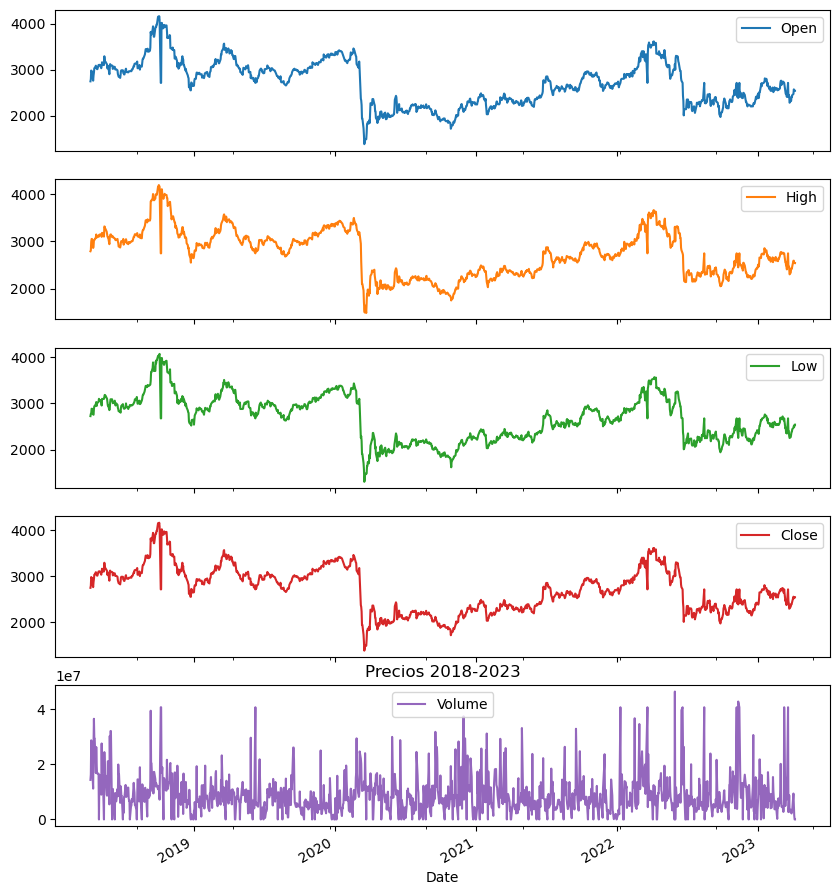

In [25]:
# Visualizacion Basica a traves de rangos
# Usando matplotlib
df_ecopetrol['2018':'2023'].plot(subplots=True, figsize=(10,12))
plt.title('Precios 2018-2023')
plt.show()

In [11]:
# Librerias para uso estadistico y de series de tiempo
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

### ACF and PACF

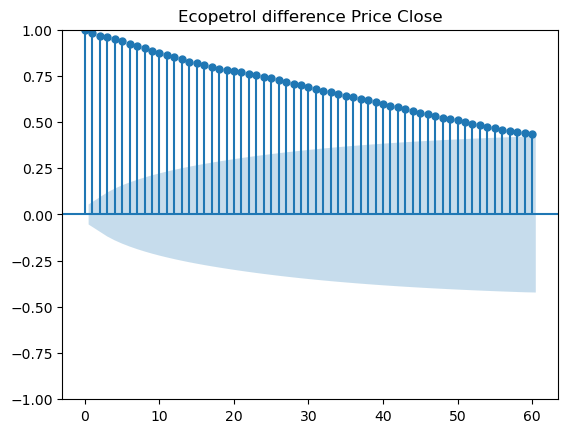

In [28]:
# Autocorrelation of Ecopetrol price Close
# Los lags van en el Eje x y las correlaciones en el Eje y
plot_acf(df_ecopetrol['Close'], lags=60,title='Ecopetrol difference Price Close')
plt.show()

#### Insights:
- Valores de precios pasados tienen una influencia sobre el precio actual.
- Especificamente para este caso valores más alla de la 59th posición no tienen poder significativo predictivo sobre el precio actual
 

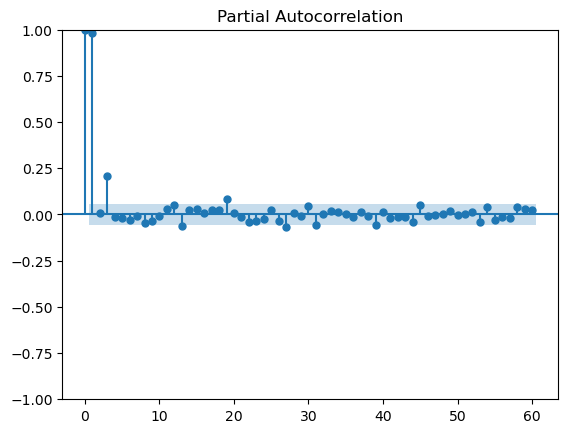

In [18]:
# Funcion Parcial de Autocorrelacion
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html
# Esta funcion genera la correlacion parcial entre los valores de una serie de tiempo y sus lags anteriores
# La correlacion parcial es un calculo de correlacion que toma en cuenta las observaciones de la serie de tiempo
# separadas por sus lags, luego de ajustar por la presencia de otros terminos con lags mas pequenos (lo que la diferencia de ACF)
# Tambien nos indica cual es la importancia de los lags en la prediccion

plot_pacf(df_ecopetrol['Close'], lags=60)
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [31]:
check_stationarity(df_ecopetrol['Close'])

ADF Statistic: -2.642439
p-value: 0.084539
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary


#### Insights:
- Dado que la serie no es estacionaria se procede a usar la diferencia (comando diff()) del precio

In [37]:
df_ecopetrol['Close_diff'] = df_ecopetrol['Close'].diff().fillna(0)

In [38]:
check_stationarity(df_ecopetrol['Close_diff'])

ADF Statistic: -31.721912
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


<AxesSubplot: xlabel='Date'>

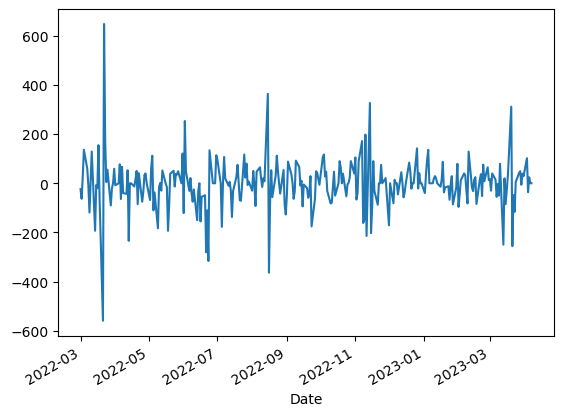

In [75]:
df_ecopetrol['Close_diff']['2022-3':].plot()

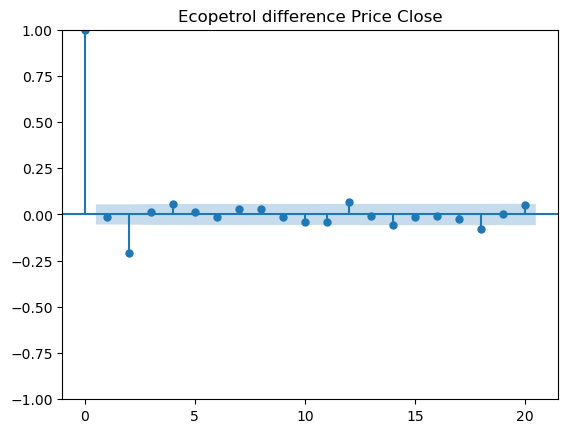

In [47]:
plot_acf(df_ecopetrol['Close_diff'], lags=20,title='Ecopetrol difference Price Close')
plt.show()

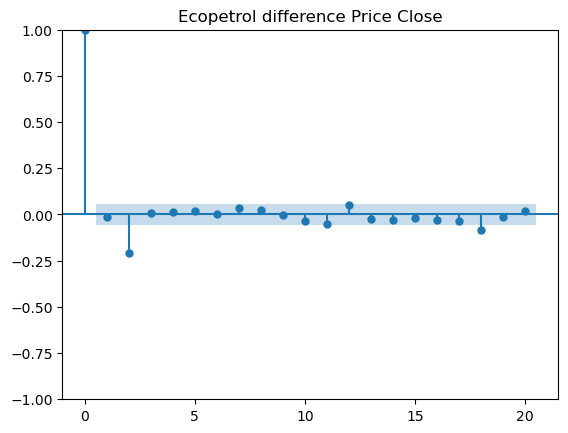

In [46]:
plot_pacf(df_ecopetrol['Close_diff'], lags=20,title='Ecopetrol difference Price Close')
plt.show()

In [53]:
df_ecopetrol['Close_diff']['2022':].describe()

count    327.000000
mean      -0.458716
std       97.195082
min     -558.528594
25%      -37.000000
50%        0.000000
75%       40.000000
max      647.528594
Name: Close_diff, dtype: float64

### Serie Geometric Brownian Motion

In [92]:
from scipy.stats import norm
import pandas as pd

#Parametros del proceso
delta=-0.46
dt=97.2
#Punto inicio
x=0
xini=24
# Numero de trayectorias
ntra = 10
# NUmero de Iteraciones
n=20
# Se pueden guardar los caminos diferentes en un dataframe
res=[]
dfres=pd.DataFrame().assign(traj=0, nsample=0, sample=0)

In [93]:
# Genera las trayectorias en un dataframe (dfres)
for i in range(ntra+1):
    for k in range(1,n+1):
         x= x+norm.rvs(scale=delta**2*dt)
         res.append(x)
         df2={'traj':i,'nsample':k,'sample':x}
         dfres=dfres.append(df2,ignore_index= True)

In [94]:
# Genera los puntos iniciales
for i in range(ntra+1):
    df2 = {'traj':i,'nsample':0,'sample':xini}
    dfres= dfres.append(df2,ignore_index=True)    

<AxesSubplot: xlabel='nsample', ylabel='sample'>

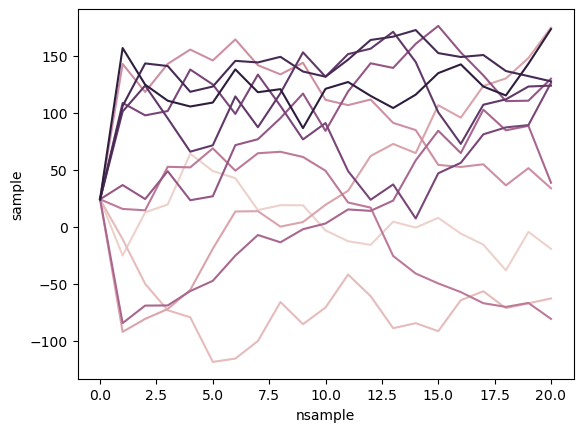

In [95]:
# Plot de las muestras
import seaborn as sns
sns.lineplot(data=dfres, x='nsample',y='sample', legend=None,ci=None, hue='traj')

In [96]:
# Se pueden obtener las trayectorias
pd.pivot_table(dfres, index=['traj'],columns=['nsample'])

sample                                                              \
nsample   0.0         1.0         2.0         3.0         4.0         5.0    
traj                                                                         
0.0       24.0  -25.334082   12.542647   19.413445   64.093366   48.809642   
1.0       24.0  -11.035214  -50.178928  -73.382765  -79.532412 -118.717510   
2.0       24.0  -92.331498  -80.955245  -72.277292  -55.531429  -19.366874   
3.0       24.0  142.779549  118.208604  142.865925  155.420342  145.859563   
4.0       24.0   15.550859   14.352393   52.513010   52.034998   68.724665   
5.0       24.0  -84.661605  -69.282520  -69.148392  -56.550126  -47.540413   
6.0       24.0   36.519594   24.224784   48.700628   23.196156   26.672336   
7.0       24.0  108.601016   97.680361  101.475878  137.905434  124.761895   
8.0       24.0  101.088415  123.806184   95.093867   65.796239   71.411993   
9.0       24.0  105.918165  143.255055  140.982054  118.367229  122.972198   
10.0      24.0  156.773578  124.617158  110.533937  105.448227  108.922656   

                                                         ...              \
nsample        6.0         7.0         8.0         9.0   ...        11.0   
traj                                                     ...               
0.0       42.544265   14.528709   18.809297   18.772612  ...  -12.757714   
1.0     -115.780706 -100.376600  -66.144212  -85.599441  ...  -42.017854   
2.0       13.286752   13.586234    0.031888    4.064507  ...   31.467709   
3.0      164.335796  141.682947  133.656411  143.798039  ...  106.668059   
4.0       49.144244   64.428490   65.725928   61.156098  ...   21.211684   
5.0      -25.444230   -7.330824  -13.729803   -2.256956  ...   15.106348   
6.0       71.546501   76.724443   95.231920  116.845268  ...  118.614299   
7.0       98.938891  133.458053  105.946166   76.576289  ...   48.788408   
8.0      114.298643   87.270151  117.104963  152.974198  ...  151.452579   
9.0      145.520697  144.126636  149.050222  136.143139  ...  146.565328   
10.0     138.056518  117.987835  120.685361   86.466239  ...  126.953861   

                                                                     \
nsample        12.0        13.0        14.0        15.0        16.0   
traj                                                                  
0.0      -15.995093    4.355834   -0.827932    7.728065   -6.103718   
1.0      -60.989596  -89.121460  -84.699520  -91.727873  -64.521773   
2.0       62.005411   72.594496   64.576672  106.568103   95.654255   
3.0      111.575727   91.080764   84.761304   54.205652   52.409218   
4.0       16.712921  -25.745227  -41.127153  -49.839758  -57.422037   
5.0       13.857329   22.886035   58.177083   84.204395   64.593486   
6.0      143.373800  139.319856  160.462447  176.174548  152.891618   
7.0       23.608536   37.055282    7.213342   46.845630   56.043196   
8.0      156.197290  171.015955  144.512420  100.368929   72.666779   
9.0      163.828069  166.764881  172.542471  152.325298  148.904572   
10.0     114.753577  104.132780  115.853825  134.750193  142.427713   

                                                         
nsample        17.0        18.0        19.0        20.0  
traj                                                     
0.0      -15.776357  -38.343143   -4.596113  -19.441299  
1.0      -56.715972  -71.538479  -67.279715  -63.002791  
2.0      123.503605  130.094367  147.996161  174.665092  
3.0       54.725953   36.253248   51.354786   33.673870  
4.0      -67.166682  -70.442891  -66.936302  -80.954998  
5.0      102.666209   84.560361   88.476370   38.572437  
6.0      132.731130  110.172609  110.548804  129.879087  
7.0       81.021753   87.136013   89.137099  126.201715  
8.0      107.015324  111.718387  122.988356  123.773743  
9.0      150.638487  136.588744  132.109271  127.550007  
10.0     122.996822  115.148130  143.008939  173.414536  

[11 rows x 21 columns]

#### modelo de Reversión a la Media

In [107]:
df_ecopetrol['Close_diff'].describe()

count    1302.000000
mean       -0.157450
std        88.018973
min     -1368.528594
25%       -25.000000
50%         0.000000
75%        30.000000
max      1303.528594
Name: Close_diff, dtype: float64

In [104]:
def mod_vasicek(r0,K,theta,sigma,T=1.,N=10,seed=777):
    np.random.seed(seed)
    dt= T/float(N)
    rates=[r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1]+dr)
    return range(N+1), rates

In [118]:
# Parametros para la serie de tiempo
r0 = 24    # The starting price - 24 porque es el último valor de la serie de la diferencia de precios de ecopetrol
K = 10     # speed of reversion parameter
theta = -0.15   # long-term mean interest rate level correction - media de la serie de la diferencia de precios de ecopetrol
sigma = 88  # instantaneous volatility - de la serie de la diferencia de precios de ecopetrol
T = 10      # end modelling time
N = 100    # 
seed = np.random.randint(100,900)
# Llama a la funcion Vasicek
x, y = mod_vasicek(r0,K, theta,sigma,T,N,seed)

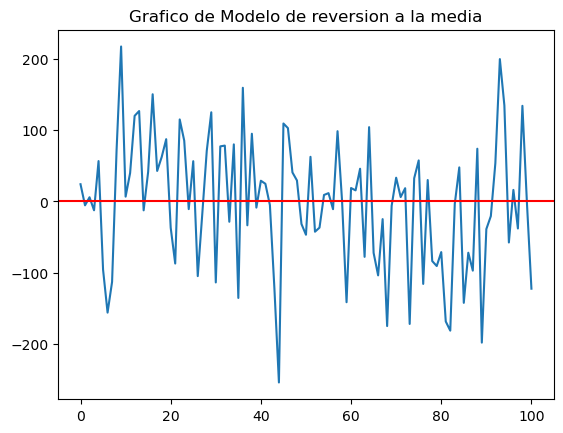

In [119]:
# Generacion de grafica del modelo de Reversion a la media
plt.plot(x,y)
plt.title('Grafico de Modelo de reversion a la media')
plt.axhline(theta, color='red')
plt.show()

### Modelo autoregresivo y de moving average
### Ejercicio de predicción de modelos
### Visualización simple de Series de Tiempo

In [132]:
# Prediccion de Precio de Ecopetrol
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

#### Dado que la libreria statsmodels tuvo una actualización reciente cambiando el uso de los modelos ARMA, se usa el modelo ARIMA con d=0

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



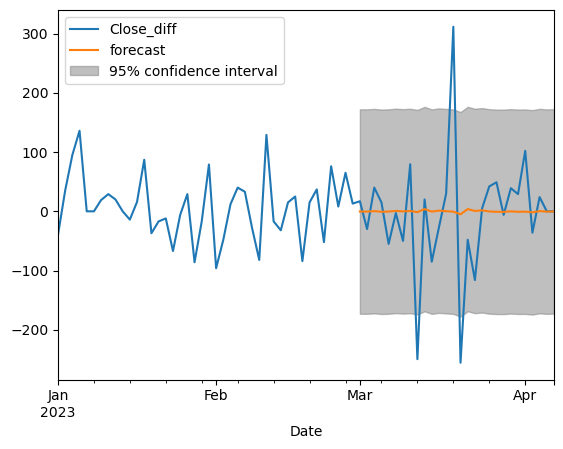

In [133]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(1,0,0))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [138]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.15745007794760113 θ=-0.015658942600525076
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7676.571
Date:                Tue, 18 Apr 2023   AIC                          15359.143
Time:                        01:52:26   BIC                          15374.657
Sample:                             0   HQIC                         15364.963
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1575      2.495     -0.063      0.950      -5.048       4.733
ar.L1         -0.0157      0.017     -0.942      0.346      -0.048       0.017
sigma

In [135]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=100.12597823175223


c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



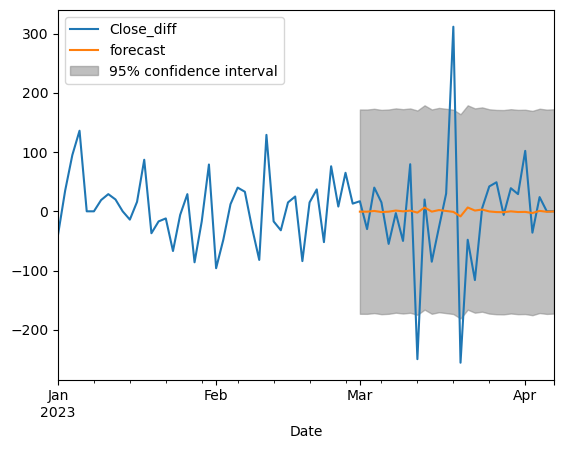

In [139]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(0,0,1))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [140]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.15745009090647907 θ=-0.026807072684995874
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7676.457
Date:                Tue, 18 Apr 2023   AIC                          15358.915
Time:                        01:54:22   BIC                          15374.430
Sample:                             0   HQIC                         15364.735
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1575      2.529     -0.062      0.950      -5.115       4.800
ma.L1         -0.0268      0.017     -1.606      0.108      -0.060       0.006
sigma

In [141]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=99.83057802026822


c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



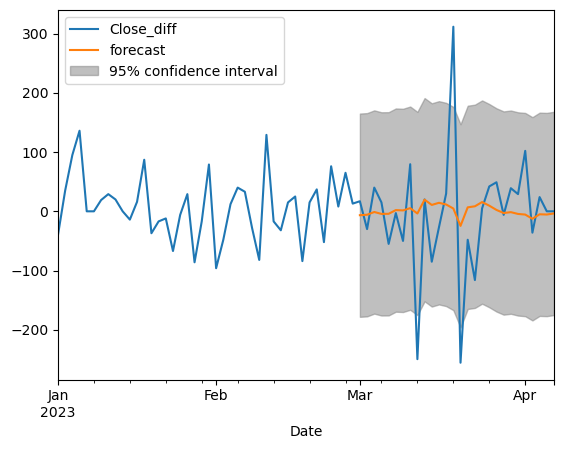

In [142]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(1,0,1))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [143]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.17204115638053777 θ=0.5548174501481203
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7669.425
Date:                Tue, 18 Apr 2023   AIC                          15346.850
Time:                        01:55:37   BIC                          15367.537
Sample:                             0   HQIC                         15354.611
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1720      2.519     -0.068      0.946      -5.110       4.766
ar.L1          0.5548      0.115      4.825      0.000       0.329       0.780
ma.L1   

In [144]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=98.30667623563063


c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



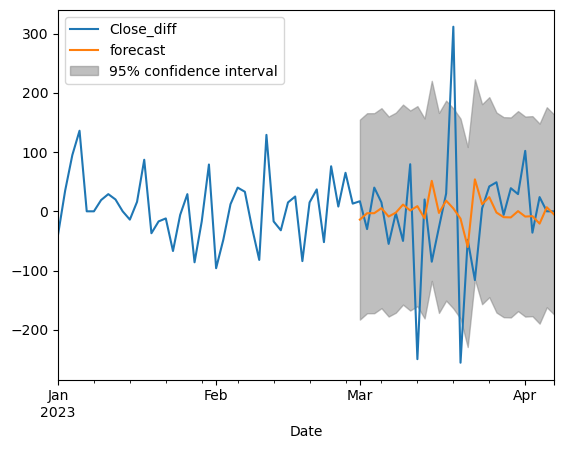

In [154]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(2,0,0))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [155]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.15745272483226536 θ=-0.018937760797467073
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7647.625
Date:                Tue, 18 Apr 2023   AIC                          15303.250
Time:                        02:01:29   BIC                          15323.936
Sample:                             0   HQIC                         15311.011
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1575      2.418     -0.065      0.948      -4.896       4.581
ar.L1         -0.0189      0.016     -1.154      0.248      -0.051       0.013
ar.L2

In [156]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=104.57478927097281


c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



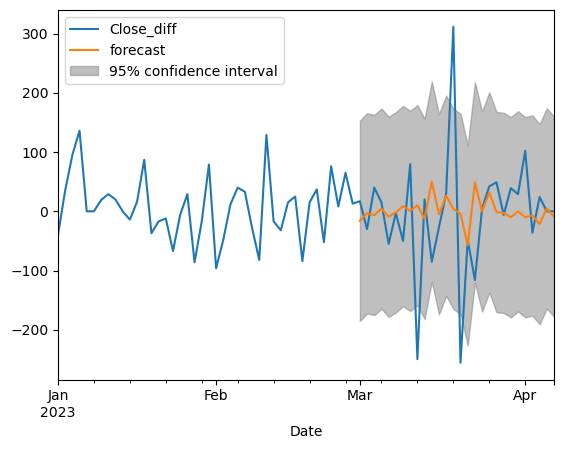

In [157]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(0,0,2))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [158]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.16716830443385736 θ=-0.010788786416524594
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7649.627
Date:                Tue, 18 Apr 2023   AIC                          15307.254
Time:                        02:02:45   BIC                          15327.941
Sample:                             0   HQIC                         15315.015
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1672      2.403     -0.070      0.945      -4.877       4.542
ma.L1         -0.0108      0.017     -0.641      0.521      -0.044       0.022
ma.L2

In [159]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=105.14053013295596


c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\oscah\anaconda3\envs\analyticscourse\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



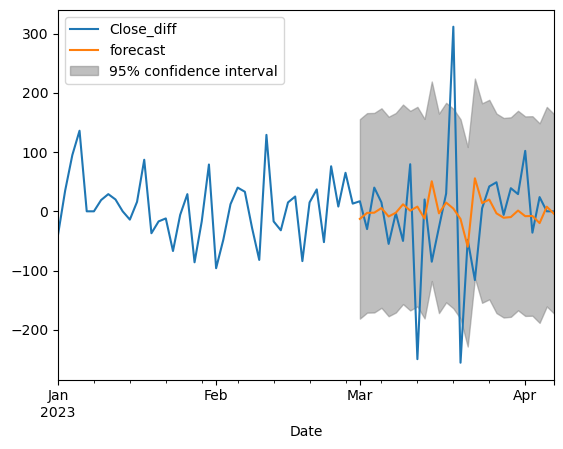

In [151]:
ecopetrol_price=ARIMA(df_ecopetrol['Close_diff'],order=(2,0,2))
res=ecopetrol_price.fit()
fig, ax = plt.subplots()
ax = df_ecopetrol['Close_diff'].loc['2023':].plot(ax=ax)
plot_predict(res,'2023-3','2023-4-7',ax=ax)
plt.show()

In [152]:
print('μ={} θ={}'.format(res.params[0],res.params[1]))
print(res.summary())

μ=-0.15747144488505752 θ=-0.044624490212892255
                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1302
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7647.481
Date:                Tue, 18 Apr 2023   AIC                          15306.962
Time:                        01:59:50   BIC                          15337.992
Sample:                             0   HQIC                         15318.604
                               - 1302                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1575      2.480     -0.064      0.949      -5.018       4.703
ar.L1         -0.0446      0.116     -0.385      0.700      -0.272       0.182
ar.L2

In [153]:
rmse=math.sqrt(mean_squared_error(df_ecopetrol['Close_diff'].loc['2023-3':'2023-4-7'].values,res.predict(start='2023-3',end='2023-4-7')))
print('RMSE={}'.format(rmse))

RMSE=104.56294393695131


#### Insights:

- De todos los modelos analizados, el que tuvo un rmse más bajo fue el arma(1,1). Sin embargo, el valor de la constante no es estadísticamente significativo.